**1. One-hot encoding**

A **codificação one-hot** é a maneira mais comum e básica de transformar um token em um vetor.  Já a usamos nos exemplos iniciais do IMDB e da Reuters (trabalhamos, nesses casos, com palavras inteiras). Consiste em associar um índice inteiro único a cada palavra e, em seguida, transformar esse índice inteiro `i` em um vetor binário de tamanho `N` (o tamanho do vocabulário); o vetor é todo composto por zeros, exceto na entrada `i`, que é 1.

A codificação *one-hot* pode ser feita também no nível de caracteres. Para deixar claro o que é a codificação *one-hot* e como implementá-la, mostremos dois exemplos práticos: um para palavras, outro para caracteres.

In [133]:
import numpy as np

In [134]:
### Word-level one-hot encoding

#Initial data: one entry per sample (in this example, a sample is a sentence,
# but it could be an entire document)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

#Builds an index of all tokens in the data; tokenizes the samples via the split
#method. In real life, we’d also strip punctuation and special characters
#from the samples.
token_index = {}
for sample in samples:
  for word in sample.split():
    if word not in token_index:
      #Assigns a unique index to each unique word.
      #Note that you don’t attribute index 0 to anything.
      token_index[word] = len(token_index) + 1

#Vectorizes the samples. We’ll only consider the first max_length words in each sample.
max_length = 10
results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))

for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = token_index.get(word)
    results[i, j, index] = 1.

In [135]:
### Character-level one-hot encoding (toy example)

import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable #All printable ASCII characters
token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
  for j, character in enumerate(sample):
    index = token_index.get(character)
    results[i, j, index] = 1.

Vale a pena notar que o Keras possui utilitários integradas para realizar a codificação *one-hot* de texto no nível de palavras ou no nível de caracteres, a partir de dados de texto bruto. É recomendável utilizar esses utilitários, pois eles cuidam de várias características importantes, como remover caracteres especiais de strings e considerar apenas as N palavras mais comuns em seu conjunto de dados (uma restrição comum para evitar lidar com espaços vetoriais de entrada muito grandes).

In [136]:
### Using Keras for word-level one-hot encoding

from tensorflow.keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

#Creates a tokenizer, configured to only take into account the 1k most common words
tokenizer = Tokenizer(num_words=1000)
#Builds the word index
tokenizer.fit_on_texts(samples)

#Turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

#How you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


Uma variante da codificação *one-hot* é o chamado **one-hot hashing trick**, que pode ser usado quando o número de tokens únicos no vocabulário é muito grande para trabalhar com eles explicitamente. Em vez de atribuir explicitamente um índice a cada palavra e manter uma referência desses índices em um dicionário, é possível fazer um *hash* de palavras em vetores de tamanho fixo. Isso é geralmente feito com uma função de hash muito eficiente. A principal vantagem desse método é que ele dispensa a manutenção de um índice explícito de palavras, o que economiza memória e permite a codificação online dos dados (é possível gerar vetores de token imediatamente, antes de ver todos os dados disponíveis). A única desvantagem deste método é que ele é suscetível a colisões de *hash*: duas palavras diferentes podem acabar com o mesmo *hash*, e subsequentemente qualquer modelo de aprendizado de máquina que examine esses *hashs* não será capaz de distinguir entre essas palavras. A probabilidade de colisões de *hash* diminui quando a dimensionalidade do espaço de *hash* é muito maior do que o número total de tokens únicos sendo considerados para o *hash*.

In [137]:
### Word-level one-hot encoding with hashing trick

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

#Stores the words as vectors of size 1k. If you have close to 1k words (or more),
#you’ll see many hash collisions, which will decrease the accuracy of this encoding method.
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    #Hashes the word into a random integer index between 0 and 1k
    index = abs(hash(word)) % dimensionality
    results[i, j, index] = 1.

**2. Word embeddings**

Outra maneira popular e poderosa de associar um vetor a uma palavra é o uso de vetores densos de palavras, também chamados de **word embeddings**. Enquanto os vetores obtidos por meio da codificação *one-hot* são binários, esparsos (principalmente compostos por zeros) e com muitas dimensões (mesma dimensionalidade que o número de palavras no vocabulário), as *word embeddings* são vetores densos de ponto flutuante (ou seja, vetores densos, em oposição a vetores esparsos). Ao contrário dos vetores de palavras obtidos por codificação *one-hot*, as *word embeddings* são aprendidas a partir dos dados. É comum ver *word embeddings* que são de dimensão 256, 512 ou 1.024 ao lidar com vocabulários muito grandes. Em contrapartida, a codificação *one-hot* de palavras geralmente leva a vetores que são de dimensão 20k ou mais (capturando um vocabulário de 20k tokens, neste caso). Portanto, as *word embeddings* compactam mais informações em dimensões muito menores.

Existem duas maneiras de obter *word embeddings*:
- Treinar *word embeddings* em conjunto com a tarefa principal que se está interessado (como classificação de documentos ou análise de sentimentos). Nesse cenário, começa-se com vetores de palavras aleatórios e, em seguida, aprende-se vetores de palavras da mesma maneira que se aprende os pesos de uma rede neural.
- Carregar no modelo *word embeddings* que foram precomputadas usando uma tarefa de aprendizagem de máquina diferente daquela que se está tentando resolver. Essas são chamadas de *word embeddings* pré-treinadas.

Vamos dar uma olhada em ambas as opções.

**2.1 Aprendendo *word embeddings* com a camada `Embedding`**

A maneira mais simples de associar um vetor denso a uma palavra é escolher o vetor aleatoriamente. O problema com essa abordagem é que o *embedding space* resultante não possui estrutura: por exemplo, as palavras "preciso" e "exato" podem acabar com *embeddings* completamente diferentes, mesmo que sejam intercambiáveis na maioria das frases. É difícil para uma rede neural profunda dar sentido a um **word embedding** tão ruidoso e não estruturado.

Para usar uma analogia um pouco mais abstrata, as relações geométricas entre vetores de palavras devem refletir as relações semânticas entre essas palavras. As *word embeddings* têm o objetivo de mapear a linguagem humana em um espaço geométrico. Por exemplo, em um *embedding space* razoável, esperaríamos que sinônimos fossem incorporados em vetores de palavras semelhantes; e, em geral, esperaríamos que a distância geométrica (como, por exemplo, a distância L2) entre dois vetores de palavras relacione-se à distância semântica entre as palavras associadas (palavras com significados diferentes são levadas a pontos distantes uma da outra, enquanto palavras relacionadas estão mais próximas). Além da distância, pode ser desejável que direções específicas e adições de vetores no **embedding space* sejam significativas.

Por exemplo, no *space embedding* de palavras da linguagem comum, exemplos de transformações geométricas significativas são vetores de "gênero" e vetores de "plural". Por exemplo, adicionando um vetor "feminino" ao vetor "rei", obtemos o vetor "rainha". Ao adicionar um vetor "plural", obtemos "reis". *Space embeddings* de palavras geralmente apresentam milhares desses vetores interpretáveis e potencialmente úteis.

Não existe um *space embedding* de palavras ideal que mapeie perfeitamente a linguagem humana e que possa ser usado para qualquer tarefa de processamento de linguagem natural. Ainda não conseguimos calcular algo desse tipo. Além disso, não existe algo como uma "linguagem humana" única, pois existem muitas línguas diferentes, e elas não são isomórficas, pois uma língua reflete uma cultura e um contexto específicos. No entanto, de forma mais pragmática, o que torna **space embedding* bom depende muito da sua tarefa: o espaço perfeito para um modelo de análise de sentimento em análises de filmes pode parecer diferente do espaço perfeito para um modelo de classificação de documentos jurídicos, já que a importância de certas relações semânticas varia de uma tarefa para outra.

Portanto, é razoável treinar um novo *word embedding* para cada nova tarefa. Felizmente, o *backpropagation* torna isso fácil, e o Keras facilita ainda mais. Trata-se de aprender os pesos de uma camada: a camada de incorporação (`Embedding` layer).



In [138]:
### Instantiating an Embedding layer

from keras.layers import Embedding

#The Embedding layer takes at least two arguments: the number of possible tokens
#(here, 1k: 1 + maximum word index) and the dimensionality of the embeddings (here, 64).
embedding_layer = Embedding(1000, 64)

A camada de incorporação (`Embedding` *layer*) é melhor compreendida como um dicionário que mapeia índices inteiros (que representam palavras específicas) para vetores densos. Ela recebe inteiros como entrada, procura esses inteiros em um dicionário interno e retorna os vetores associados. É efetivamente uma pesquisa em um dicionário.

A `Embedding` *layer* recebe como entrada um tensor 2D de inteiros, com forma `(amostras, comprimento_sequência)`, em que cada entrada é uma sequência de inteiros. Ela pode incorporar sequências de comprimentos variáveis: por exemplo, você poderia fornecer à camada de incorporação no exemplo anterior lotes com formas `(32, 10)` (lote de 32 sequências de comprimento 10) ou (64, 15) (lote de 64 sequências de comprimento 15). No entanto, todas as sequências em um lote devem ter o mesmo comprimento (porque é necessário agrupá-las em um único tensor), assim, sequências mais curtas que as outras devem ser preenchidas com zeros, e sequências mais longas devem ser truncadas.

Essa camada retorna um tensor flutuante 3D com forma `(amostras, comprimento_sequência, dimensionalidade_incorporação)`. Esse tensor 3D pode ser então processado por uma camada RNN ou por uma camada de convolução 1D (ambas serão introduzidas a seguir).

Quando você instancia uma camada `Embedding`, seus pesos (seu dicionário interno de vetores de *tokens*) são inicialmente aleatórios, assim como em qualquer outra camada. Durante o treinamento, esses vetores de palavras são ajustados gradualmente por meio de *backpropagation*, estruturando o espaço em algo que o modelo subsequente pode explorar. Uma vez totalmente treinado, o *embedding space* mostrará muita estrutura - uma espécie de estrutura especializada para o problema específico para o qual se está treinando o modelo.

Vamos aplicar essa ideia à tarefa de previsão de sentimento de resenhas de filmes do IMDB, com a qual já estamos familiarizados. Primeiro, vamos preparar os dados rapidamente. Restringiremos as avaliações de filmes às 10k palavras mais comuns (como fizemos da primeira vez trabalhamos com este conjunto de dados) e cortaremos as avaliações após apenas 20 palavras. A rede aprenderá *embeddings* de 8 dimensões para cada uma das 10k palavras, transformará a sequência de inteiros de entrada (representando palavras) em sequências de vetores de *embedding*. Esses vetores, depois, serão achatados e passarão por uma camada Dense para realizar a tarefa de previsão de sentimento.

In [139]:
from keras.utils import set_random_seed

In [149]:
### Loading the IMDB data for use with an Embedding layer

from keras.datasets import imdb
from keras import preprocessing

max_features = 10000  #Number of words to consider as features
maxlen = 20 #Cuts off the text after this number of words (among the max_features most common words)

#Loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen
x_train_first20 = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='pre')
x_test_first20 = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, padding='pre')

In [150]:
### Using an Embedding layer and classifier on the IMDB data

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Input

set_random_seed(0)

model_first20 = Sequential()
#Specifies the maximum input length to the Embedding layer so you can later
#flatten the embedded inputs. After the Embedding layer, the activations have
#shape (samples, maxlen, 8).
model_first20.add(Input(shape=(maxlen,), dtype='int32'))
model_first20.add(Embedding(10000, 8))

#Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen*8)
model_first20.add(Flatten())

#Adds the classifier on top
model_first20.add(Dense(1, activation='sigmoid'))
model_first20.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model_first20.summary()

history_first20 = model_first20.fit(x_train_first20, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 20, 8)          │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,161 (313.13 KB)

 Trainable params: 80,161 (313.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5721 - loss: 0.6821 - val_acc: 0.7010 - val_loss: 0.6040
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.7442 - loss: 0.5557 - val_acc: 0.7310 - val_loss: 0.5254
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.7844 - loss: 0.4693 - val_acc: 0.7458 - val_loss: 0.5031
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8061 - loss: 0.4280 - val_acc: 0.7556 - val_loss: 0.4972
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8216 - loss: 0.4005 - val_acc: 0.7546 - val_loss: 0.4974
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8370 - loss: 0.3783 - val_acc: 0.7556 - val_loss: 0.5007
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8481 - loss: 0.3583 - val_acc: 0.7556 - val_loss: 0.5059
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8574 - loss: 0.3396 - val_acc: 0.7530 - val_loss: 0.5126
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - ac

Conseguimos uma precisão de validação de aproximadamente 76%, o que é muito boa considerando que está apenas examinando as primeiras 20 palavras de cada avaliação. Mas vale observar que simplesmente achatar as sequências incorporadas e treinar uma única camada densa no topo leva a um modelo que trata cada palavra na sequência de entrada separadamente, sem considerar as relações entre as palavras e a estrutura da frase. É muito melhor adicionar camadas recorrentes ou camadas convolucionais 1D sobre as sequências incorporadas para aprender características que levem em conta cada sequência como um todo. É nisso que vamos focar em seguida.

**Exercício 1**
1. Considere, em vez das primeiras 20 palavras, as 20 últimas palavras de cada resenha, e compare os resultados.
2. Considere, em vez das primeiras 20 palavras, as primeiras 30 palavras de cada resenha, e compare os resultados.


### 1. Considere, em vez das primeiras 20 palavras, as 20 últimas palavras de cada resenha, e compare os resultados.

In [151]:
max_features = 10000  #Number of words to consider as features
maxlen = 20 #Cuts off the text after this number of words (among the max_features most common words)

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen),
# Taking the last 20 words of each review
x_train_last20 = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test_last20 = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, padding='post')

In [31]:
set_random_seed(0)

model_last20 = Sequential()
#Specifies the maximum input length to the Embedding layer so you can later
#flatten the embedded inputs. After the Embedding layer, the activations have
#shape (samples, maxlen, 8).
model_last20.add(Input(shape=(maxlen,), dtype='int32'))
model_last20.add(Embedding(10000, 8))

#Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen*8)
model_last20.add(Flatten())

#Adds the classifier on top
model_last20.add(Dense(1, activation='sigmoid'))
model_last20.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model_last20.summary()

history_last20 = model_last20.fit(x_train_last20, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 20, 8)          │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,161 (313.13 KB)

 Trainable params: 80,161 (313.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.5721 - loss: 0.6821 - val_acc: 0.7010 - val_loss: 0.6040
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.7442 - loss: 0.5557 - val_acc: 0.7310 - val_loss: 0.5254
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.7844 - loss: 0.4693 - val_acc: 0.7458 - val_loss: 0.5031
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - acc: 0.8061 - loss: 0.4280 - val_acc: 0.7556 - val_loss: 0.4972
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8216 - loss: 0.4005 - val_acc: 0.7546 - val_loss: 0.4974
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - acc: 0.8370 - loss: 0.3783 - val_acc: 0.7556 - val_loss: 0.5007
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - acc: 0.8481 - loss: 0.3583 - val_acc: 0.7556 - val_loss: 0.5059
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - acc: 0.8574 - loss: 0.3396 - val_acc: 0.7530 - val_loss: 0.5126
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 998us

In [32]:
import matplotlib.pyplot as plt

In [33]:
def plot_train_val_charts(history1, history2, model_1_label='1', model_2_label='2', save_path='', color_1='b', color_2='r'):
    """
    Compare two models training and validation loss and accuracy
    """
    history_dict1 = history1.history
    history_dict2 = history2.history
    loss_values1 = history_dict1['loss']
    val_loss_values1 = history_dict1['val_loss']
    loss_values2 = history_dict2['loss']
    val_loss_values2 = history_dict2['val_loss']
    acc1 = history1.history['acc']
    acc2 = history2.history['acc']
    val_acc1 = history1.history['val_acc']
    val_acc2 = history2.history['val_acc']
    epochs = range(1, len(acc1) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values1, f'{color_1}o', label=f'Training loss Model {model_1_label}')
    plt.plot(epochs, val_loss_values1, color_1, label=f'Validation loss Model {model_1_label}')
    plt.plot(epochs, loss_values2, f'{color_2}o', label=f'Training loss Model {model_2_label}')
    plt.plot(epochs, val_loss_values2, color_2, label=f'Validation loss Model {model_2_label}')
    plt.xticks(epochs)
    plt.title(f'Training and validation loss Model {model_1_label} vs Model {model_2_label}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc1, f'{color_1}o', label=f'Training acc Model {model_1_label}')
    plt.plot(epochs, val_acc1, color_1, label=f'Validation acc Model {model_1_label}')
    plt.plot(epochs, acc2, f'{color_2}o', label=f'Training acc Model {model_2_label}')
    plt.plot(epochs, val_acc2, color_2, label=f'Validation acc Model {model_2_label}')
    plt.xticks(epochs)
    plt.title(f'Training and validation accuracy Model {model_1_label} vs Model {model_2_label}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

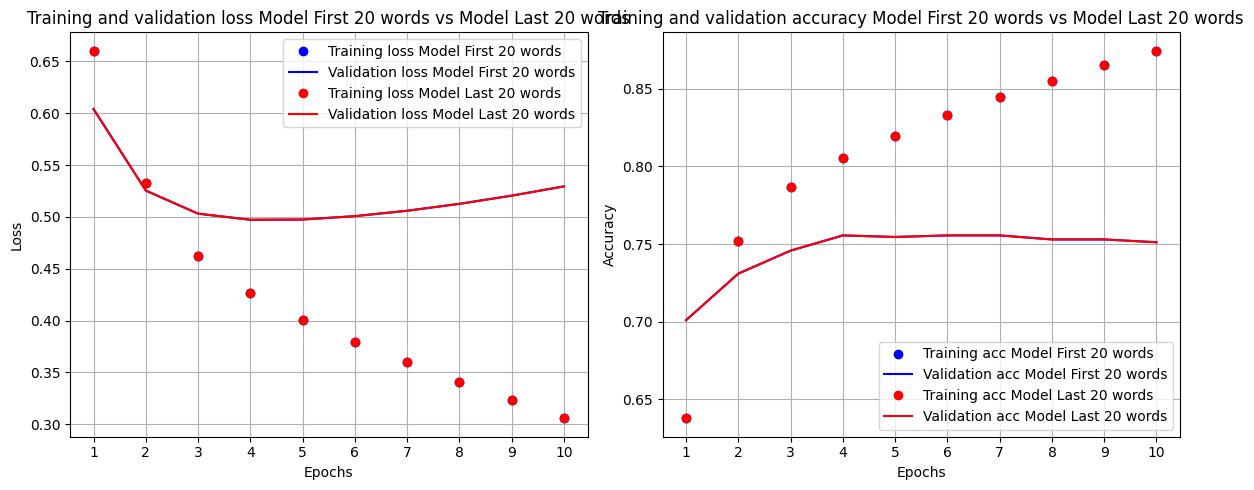

In [34]:
plot_train_val_charts(history_first20, history_last20, model_1_label='First 20 words', model_2_label='Last 20 words',
                     save_path='./imgs/first_vs_last_20_words.png')

In [44]:
model_first20.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - acc: 0.7568 - loss: 0.5247


[0.5180893540382385, 0.757319986820221]

In [45]:
model_last20.evaluate(x_test_last20, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - acc: 0.7568 - loss: 0.5247


[0.5180893540382385, 0.757319986820221]

In [36]:
x_train_last20[0]

array([  65,   16,   38, 1334,   88,   12,   16,  283,    5,   16, 4472,
        113,  103,   32,   15,   16, 5345,   19,  178,   32])

In [40]:
x_train[0]

array([  65,   16,   38, 1334,   88,   12,   16,  283,    5,   16, 4472,
        113,  103,   32,   15,   16, 5345,   19,  178,   32])

### 2. Considere, em vez das primeiras 20 palavras, as primeiras 30 palavras de cada resenha, e compare os resultados

In [41]:
max_features = 10000  #Number of words to consider as features
maxlen = 30 #Cuts off the text after this number of words (among the max_features most common words)

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen),
# Taking the last 20 words of each review
x_train_first30 = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='pre')
x_test_first30 = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, padding='pre')

In [42]:
set_random_seed(0)

model_first30 = Sequential()
#Specifies the maximum input length to the Embedding layer so you can later
#flatten the embedded inputs. After the Embedding layer, the activations have
#shape (samples, maxlen, 8).
model_first30.add(Input(shape=(maxlen,), dtype='int32'))
model_first30.add(Embedding(10000, 8))

#Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen*8)
model_first30.add(Flatten())

#Adds the classifier on top
model_first30.add(Dense(1, activation='sigmoid'))
model_first30.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model_first30.summary()

history_first30 = model_first30.fit(x_train_first30, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 30, 8)          │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,241 (313.44 KB)

 Trainable params: 80,241 (313.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.5541 - loss: 0.6864 - val_acc: 0.6968 - val_loss: 0.6213
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - acc: 0.7360 - loss: 0.5746 - val_acc: 0.7292 - val_loss: 0.5295
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - acc: 0.7800 - loss: 0.4767 - val_acc: 0.7434 - val_loss: 0.5033
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - acc: 0.8039 - loss: 0.4317 - val_acc: 0.7492 - val_loss: 0.4969
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8223 - loss: 0.4031 - val_acc: 0.7550 - val_loss: 0.4970
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - acc: 0.8338 - loss: 0.3808 - val_acc: 0.7548 - val_loss: 0.5002
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - acc: 0.8440 - loss: 0.3611 - val_acc: 0.7552 - val_loss: 0.5049
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - acc: 0.8528 - loss: 0.3427 - val_acc: 0.7516 - val_loss: 0.5108
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1

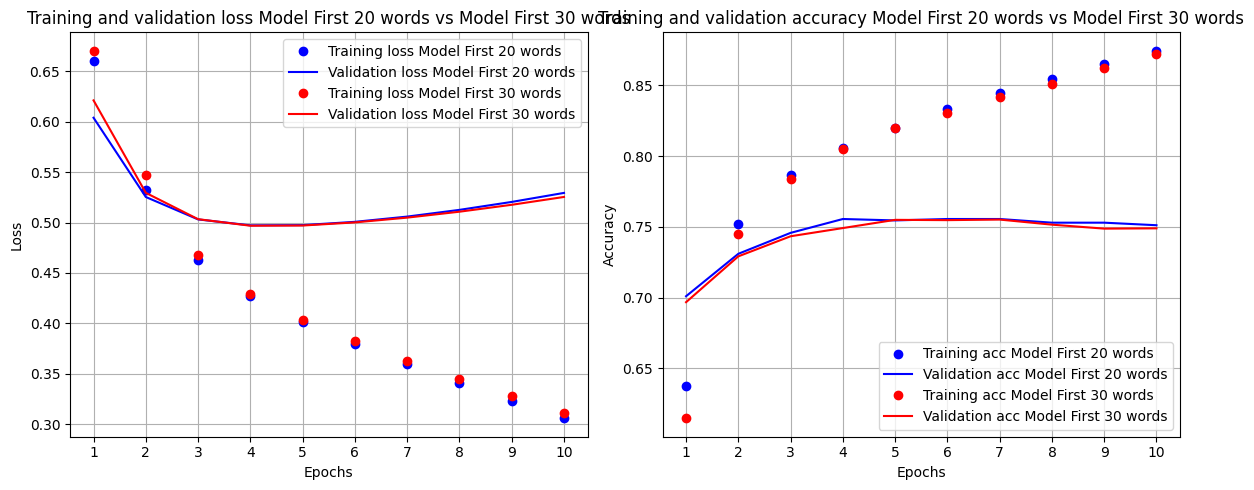

In [43]:
plot_train_val_charts(history_first20, history_first30, model_1_label='First 20 words', model_2_label='First 30 words',
                        save_path='./imgs/first20_vs_first30_words.png')

In [48]:
model_first20.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - acc: 0.7568 - loss: 0.5247


[0.5180893540382385, 0.757319986820221]

In [49]:
model_first30.evaluate(x_test_first30, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - acc: 0.7562 - loss: 0.5193


[0.5117917060852051, 0.758679986000061]

**Análise**:

O modelo que leva em consideração mais palavras apresentou uma acurácia ligeralmente maior

**2.2 Usando *embeddings* pré-treinadas**

Às vezes, temos tão poucos dados de treinamento disponíveis que não podemos usar apenas os dados para aprender uma *embedding* específica da tarefa para o nosso vocabulário. O que fazer nesse caso?

Em vez de aprender *embeddings* de palavras em conjunto com o problema que se deseja resolver, pode-se carregar vetores de *embedding* de um espaço de *embedding* pré-computado que se sabe ser altamente estruturado e exibir propriedades úteis — que captura aspectos genéricos da estrutura da linguagem. A lógica por trás do uso de *embeddings* de palavras pré-treinados no processamento de linguagem natural é bastante semelhante ao uso de *convnets* pré-treinadas na classificação de imagens: não se tem dados suficientes disponíveis para aprender recursos verdadeiramente poderosos por conta própria, mas espera-se que os recursos necessários sejam bastante genéricos — ou seja, recursos visuais comuns ou recursos semânticos. Nesse caso, faz sentido reutilizar recursos aprendidos em um problema diferente.

Tais *embeddings* de palavras geralmente são calculadas usando estatísticas de ocorrência de palavras (observações sobre quais palavras coocorrem em frases ou documentos), empregando uma variedade de técnicas, algumas envolvendo redes neurais e outras não. A ideia de um espaço de *embedding* denso e de baixa dimensão para palavras, calculado de maneira não supervisionada, foi explorada inicialmente por Bengio et al. no início dos anos 2000, mas só começou a ganhar destaque em pesquisas e aplicações industriais após o lançamento de um dos esquemas de *embedding* de palavras mais famosos e bem-sucedidos: o algoritmo Word2vec (https://code.google.com/archive/p/word2vec), desenvolvido por Tomas Mikolov na Google em 2013. As dimensões do Word2vec capturam propriedades semânticas específicas, como gênero.

Existem diversos bancos de dados precomputados de *embeddings* de palavras que podemos baixar e utilizar em uma camada `Embedding` do Keras. O Word2vec é um deles. Outro bastante popular é chamado de Global Vectors for Word Representation (GloVe, https://nlp.stanford.edu/projects/glove), desenvolvido por pesquisadores da Stanford em 2014. Esta técnica de *embedding* é baseada na fatorização de uma matriz de estatísticas de coocorrência de palavras. Seus desenvolvedores disponibilizaram *embeddings* precomputados para milhões de tokens em inglês, obtidos a partir de dados da Wikipedia e da Common Crawl.

**3. Colocando em prática**

Usaremos um modelo semelhante ao que acabamos de discutir: fazendo *embedding* sentenças em sequências de vetores, achatando-as (com a camada `Flatten`) e treinando uma camada `Dense` no topo. No entanto, faremos isso usando *embeddings* de palavras pré-treinados; e, em vez de usar os dados pré-tokenizados do IMDB embutidos no Keras, começaremos do zero baixando os dados originais de texto.



**3.1 Fazendo o download dos dados do IMDB em formato de texto bruto**

Primeiro, vá para http://mng.bz/0tIo e baixe o conjunto de dados IMDB bruto. Descompacte-o.

Agora, vamos coletar as avaliações individuais de treinamento em uma lista de strings, uma string por avaliação. Também iremos coletar os rótulos das avaliações (positivo/negativo) em uma lista de rótulos.

In [53]:
import os

In [56]:
imdb_dir = './extracted/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding="utf8")
      texts.append(f.read())
      f.close()
    if label_type == 'neg':
      labels.append(0)
    else:
      labels.append(1)

**Tokenizando os tados**

Vamos vetorizar o texto e preparar uma divisão entre treinamento e validação, utilizando os conceitos introduzidos anteriormente. Como as *embeddings* de palavras pré-treinadas são projetadas para serem especialmente úteis em problemas nos quais há pouco dado de treinamento disponível (caso contrário, as *embeddings* específicas da tarefa provavelmente as superarão), faremos o seguinte: restringindo os dados de treinamento aos primeiros 200 exemplos. Assim, aprenderemos a classificar análises de filmes após examinar apenas 200 exemplos.

In [115]:
### Tokenizing the text of the raw IMDB data

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                #Cuts off reviews after 100 words
training_samples = 200      #Trains on 200 samples
validation_samples = 10000  #Validates on 10k samples
max_words = 10000           #Considers only the top 10k words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#Splits the data into a training set and a validation set, but first shuffles
#the data, because you’re starting with data in which samples are ordered (all
#negative first, then all positive)
np.random.seed(0)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels_ = labels[indices]

x_train = data[:training_samples]
y_train = labels_[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels_[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


**Fazendo o download de GloVe Word Embeddings**

Acesse https://nlp.stanford.edu/projects/glove e faça o download das *embeddings* pré-calculadas da Wikipedia em inglês de 2014. É um arquivo zip de 822 MB chamado glove.6B.zip, contendo vetores de *embedding* de 100 dimensões para 400k palavras (ou tokens não palavras). Descompacte-o.

**Pré-processando as embeddings**
Vamos processar o arquivo descompactado (um arquivo .txt) para construir um índice que mapeia palavras (strings) para sua representação vetorial (vetores numéricos).


In [72]:
### Parsing the GloVe word-embeddings file

glove_dir = './glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


A seguir, construiremos uma matriz de *embedding* que pode ser carregada em uma camada de `Embedding`. Deve ser uma matriz com formato (max_words, embedding_dim), onde cada entrada `i` contém o vetor de dimensão `embedding_dim` para a palavra de índice `i` no índice de palavras de referência (construído durante a tokenização). Observe que o índice 0 não deve representar nenhuma palavra ou token - é um espaço reservado.

In [73]:
### Preparing the GloVe word-embeddings matrix

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [103]:
### Model definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

set_random_seed(0)

embedding_layer =  Embedding(max_words, embedding_dim, trainable=False)
embedding_layer.build((None, ))
embedding_layer.set_weights([embedding_matrix])

model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(Flatten())
model_glove.add(Dense(32, activation='relu'))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

**Carregando a GloVe embedding no modelo**

A camada de `Embedding` possui uma única matriz de pesos: uma matriz de números reais (float) 2D, onde cada entrada `i` é o vetor de palavra destinado a ser associado ao índice `i`. Vamos carregá-la.

Além disso, congelaremos a camada de `Embedding` (definindo seu atributo `trainable` como `False`), seguindo a mesma lógica com a qual já estamos familiarizado no contexto de características de convnet pré-treinadas: quando partes de um modelo são pré-treinadas (como sua camada de `Embedding`) e partes são inicializadas aleatoriamente (como o classificador), as partes pré-treinadas não devem ser atualizadas durante o treinamento, para evitar esquecer o que já sabem. As atualizações de gradientes grandes desencadeadas pelas camadas inicializadas aleatoriamente seriam disruptivas para as características já aprendidas.

In [104]:
### Training and evaluation
set_random_seed(0)

model_glove.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model_glove.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
os.makedirs('./models', exist_ok=True)
model_glove.save_weights('./models/pre_trained_glove_model.weights.h5')

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - acc: 0.4087 - loss: 2.5155 - val_acc: 0.5011 - val_loss: 0.8545
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.7170 - loss: 0.4698 - val_acc: 0.5551 - val_loss: 0.6903
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9278 - loss: 0.3147 - val_acc: 0.5394 - val_loss: 0.7240
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.9783 - loss: 0.2025 - val_acc: 0.5591 - val_loss: 0.6967
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 0.9867 - loss: 0.1526 - val_acc: 0.5644 - val_loss: 0.7027
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - acc: 0.9810 - loss: 0.1396 - val_acc: 0.5279 - val_loss: 0.8327
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9142 - loss: 0.3215 - val_acc: 0.5584 - val_loss: 0.7387
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 1.0000 - loss: 0.0504 - val_acc: 0.5656 - val_loss: 0.7447
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 1.0000 - loss: 0.0316 - 

In [120]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plotting training and validation accuracy
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'b', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.legend()
    
    # Plotting training and validation loss
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'b', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.legend()
    
    plt.show()

# Usage example
# plot_training_results(history)


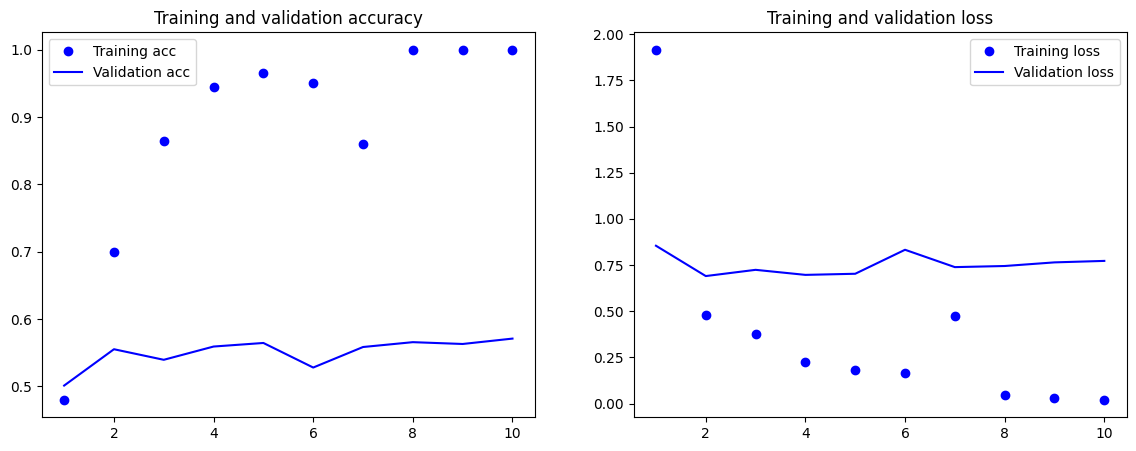

In [121]:
plot_training_results(history)

**Exercício 2**
1. O modelo começa a sofrer *overfitting* rapidamente ou não?
2. Repita o exemplo duas vezes, pegando novos dados aleatórios a cada vez. Os resultados são praticamente os mesmos ou muito diferentes a cada vez?
3. Tente treinar o mesmo modelo sem carregar a camada pré-treinada e sem congelar a camada de `Embedding`. Compare os resultados do novo modelo com o modelo original.
4. Tente aumentar o número de amostras de treinamento significativamente e compare novamente os resultados do modelo gerado com o modelo original.

In [124]:
def fit_model(data, n_times, seed=None, pre_trained_embedding=[embedding_matrix], imdb_dir='./extracted/aclImdb/'):
    """
    Random fits data into a model
    Returns a list of histories and a list of models
    """
    if seed:
        set_random_seed(seed)
        np.random.seed(seed)
    histories = []
    models = []
    for _ in range(n_times):
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        data = data[indices]
        labels_ = labels[indices]

        x_train = data[:training_samples]
        y_train = labels_[:training_samples]
        x_val = data[training_samples: training_samples + validation_samples]
        y_val = labels_[training_samples: training_samples + validation_samples]

        if pre_trained_embedding:
            embedding_layer =  Embedding(max_words, embedding_dim, trainable=False)
            embedding_layer.build((None, ))
            embedding_layer.set_weights([embedding_matrix])
        else:
            embedding_layer = Embedding(max_words, embedding_dim)

        model = Sequential()
        model.add(embedding_layer)
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
        history = model.fit(x_train, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(x_val, y_val))
        histories.append(history)
        models.append(model)
    return histories, models

### 1. O modelo começa a sofrer *overfitting* rapidamente ou não?

Sim, com poucas épocas o modelo já atingiu uma acurácia de 100% no treino

### 2. Repita o exemplo duas vezes, pegando novos dados aleatórios a cada vez. Os resultados são praticamente os mesmos ou muito diferentes a cada vez?

In [119]:
hists, models = fit_model(data, 2, pre_trained_embedding=False)

[ 7914 22909 21038 ...  3662  2398 21647]
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - acc: 0.5247 - loss: 0.6931 - val_acc: 0.5134 - val_loss: 0.6922
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - acc: 0.9755 - loss: 0.5693 - val_acc: 0.5143 - val_loss: 0.6917
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.9782 - loss: 0.4230 - val_acc: 0.5261 - val_loss: 0.6923
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 0.9931 - loss: 0.2551 - val_acc: 0.5267 - val_loss: 0.6952
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 1.0000 - loss: 0.1395 - val_acc: 0.5310 - val_loss: 0.6997
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 1.0000 - loss: 0.0784 - val_acc: 0.5304 - val_loss: 0.7056
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 1.0000 - loss: 0.0465 - val_acc: 0.5279 - val_loss: 0.7131
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 1.0000 - loss: 0.0294 - val_acc: 0.5307 - val_loss: 0.7199
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s

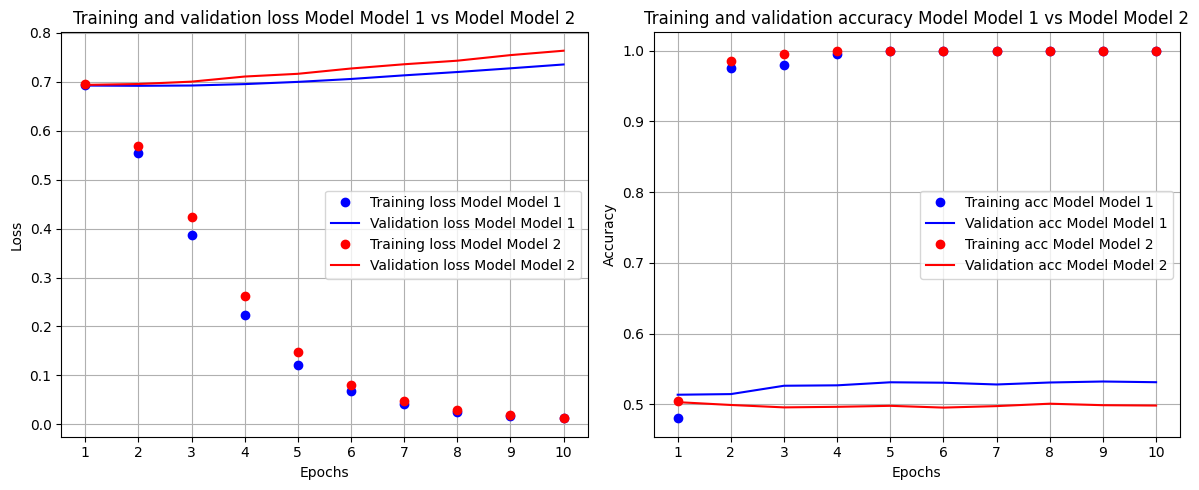

In [122]:
plot_train_val_charts(hists[0], hists[1], model_1_label='Model 1', model_2_label='Model 2',
                        save_path='./imgs/model1_vs_model2_glove.png')

Os resultados tem uma variabilidade até significativa, mas não muito grande

### 3. Tente treinar o mesmo modelo sem carregar a camada pré-treinada e sem congelar a camada de `Embedding`. Compare os resultados do novo modelo com o modelo original.

In [123]:
hists, models = fit_model(data, 1, pre_trained_embedding=True)

[ 7273   723  6838 ... 20658 11339 22833]
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - acc: 0.5070 - loss: 1.7891 - val_acc: 0.5034 - val_loss: 1.1058
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 890ms/step - acc: 0.6037 - loss: 0.7563 - val_acc: 0.5039 - val_loss: 0.8673
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - acc: 0.7463 - loss: 0.6337 - val_acc: 0.5075 - val_loss: 0.8378
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - acc: 0.8622 - loss: 0.3811 - val_acc: 0.5061 - val_loss: 1.2884
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.8384 - loss: 0.3131 - val_acc: 0.5068 - val_loss: 1.8208
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.9048 - loss: 0.2634 - val_acc: 0.5566 - val_loss: 0.8055
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.8894 - loss: 0.2400 - val_acc: 0.5266 - val_loss: 0.9718
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - acc: 1.0000 - loss: 0.0556 - val_acc: 0.5144 - val_loss: 1.4485
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

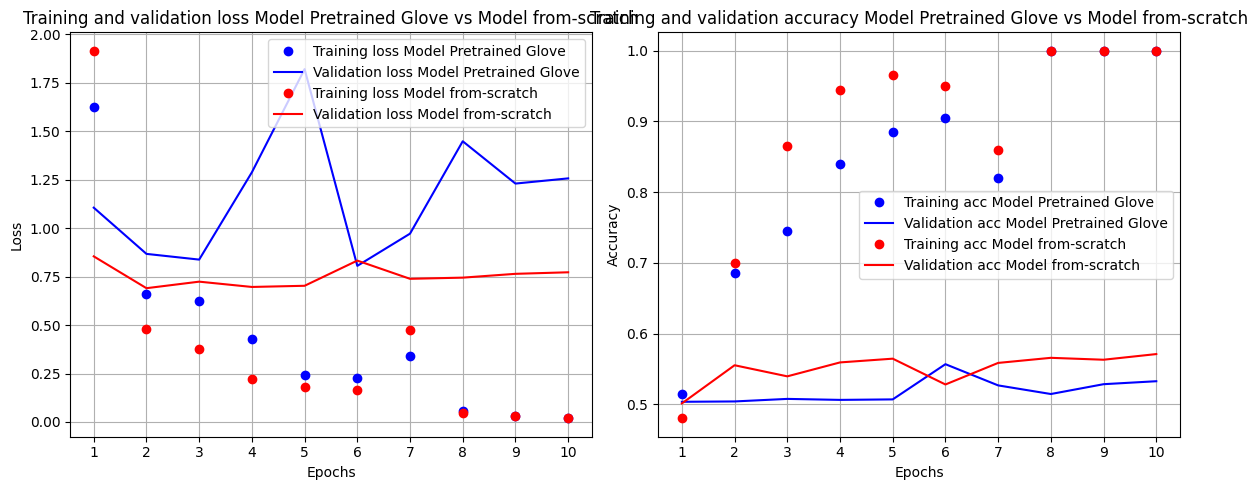

In [125]:
plot_train_val_charts(hists[0], history, model_1_label='Pretrained Glove', model_2_label='from-scratch',
                        save_path='./imgs/pretrained_vs_from_scratch_glove.png')

O modelo sem a camada pré-treinada e sem congelar a camada de `Embedding` apresentou uma acurácia de validação melhor do que o modelo pré-treinado

### 4. Tente aumentar o número de amostras de treinamento significativamente e compare novamente os resultados do modelo gerado com o modelo original.

In [126]:
data

array([[1158, 5401,    4, ...,    3,  391, 4369],
       [1919,    5,  120, ...,   71,   11,   28],
       [   0,    0,    0, ...,   27,   32, 8128],
       ...,
       [   1,   93,   26, ...,    9,  141,   27],
       [   1,  894, 4951, ...,    9,  195,   29],
       [   2,   54,  402, ...,   77,  568,  167]])

In [128]:
maxlen = 100                #Cuts off reviews after 100 words
training_samples = 2000      #Trains on 200 samples
validation_samples = 10000  #Validates on 10k samples
max_words = 10000           #Considers only the top 10k words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#Splits the data into a training set and a validation set, but first shuffles
#the data, because you’re starting with data in which samples are ordered (all
#negative first, then all positive)
np.random.seed(0)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels_ = labels[indices]

x_train = data[:training_samples]
y_train = labels_[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels_[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [129]:
### Preparing the GloVe word-embeddings matrix

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [130]:
set_random_seed(0)

embedding_layer =  Embedding(max_words, embedding_dim, trainable=False)
embedding_layer.build((None, ))
embedding_layer.set_weights([embedding_matrix])

model_glove2k = Sequential()
model_glove2k.add(embedding_layer)
model_glove2k.add(Flatten())
model_glove2k.add(Dense(32, activation='relu'))
model_glove2k.add(Dense(1, activation='sigmoid'))
model_glove2k.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [131]:
### Training and evaluation
set_random_seed(0)

model_glove2k.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_glove2k = model_glove2k.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
os.makedirs('./models', exist_ok=True)
model_glove2k.save_weights('./models/pre_trained_glove_model_2k.weights.h5')

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.5149 - loss: 1.0113 - val_acc: 0.5049 - val_loss: 0.6935
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.5822 - loss: 0.8601 - val_acc: 0.5059 - val_loss: 0.6960
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.6431 - loss: 0.7727 - val_acc: 0.5038 - val_loss: 0.8967
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.7413 - loss: 0.5751 - val_acc: 0.5026 - val_loss: 1.1608
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.7677 - loss: 0.5018 - val_acc: 0.5029 - val_loss: 1.0496
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8570 - loss: 0.3236 - val_acc: 0.5036 - val_loss: 1.2711
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9106 - loss: 0.2404 - val_acc: 0.5046 - val_loss: 1.1928
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9241 - loss: 0.1959 - val_acc: 0.5070 - val_loss: 1.1257
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9633 

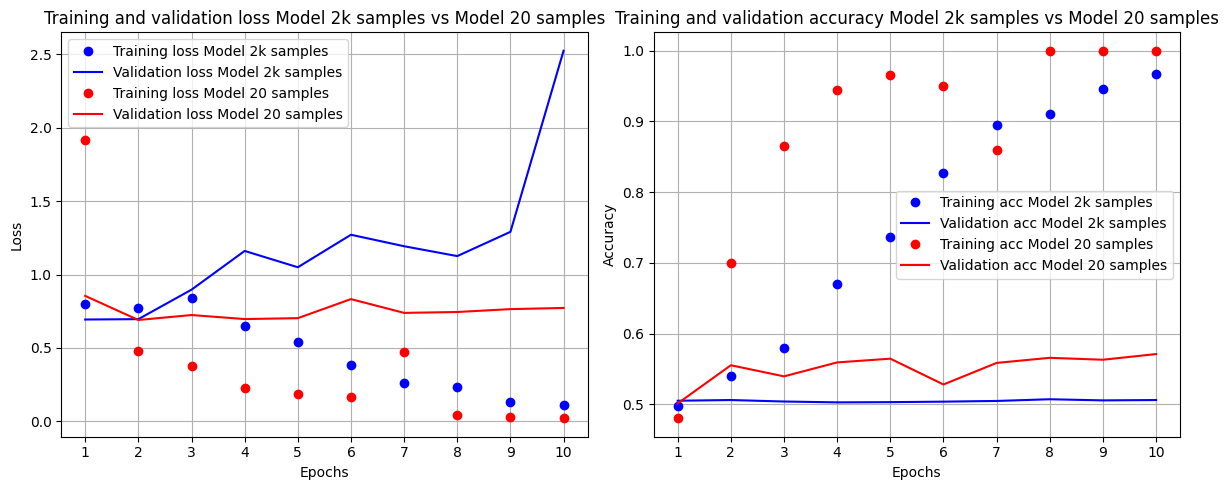

In [132]:
plot_train_val_charts(history_glove2k, history, model_1_label='2k samples', model_2_label='20 samples',
                        save_path='./imgs/2k_vs_20_samples_glove.png')

O modelo com mais palavras de treinamento apresentou uma acurácia de validação menor do que o modelo original